In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from tqdm.notebook import tqdm, trange

In [3]:
%load_ext autoreload
%autoreload 2

from hex_show import *
from hex_pathfinding import *
from hex_helpers import *
from hex_minmax import *
from hex_train_helpers import *

bsize=6

## Initialisierung

In [4]:

class RandomPlayer:
    @staticmethod
    def findmove(board):
        while True:
            k = np.random.randint(N**2)
            if board[divmod(k,N)]==0:
                return divmod(k,N)

## Pitting

In [162]:
# Funktion für das pitten zweier ai`s (Wettkampf mit n Runden)

def pit(ai1, ai2, n=20, nrnd=0, verbose=0):
    '''Pits two ai for n rounds. First nrnd moves are randomly chosen.
    confidence: sigma interval in where you want to know one ai is better than the other
    '''
        
    if type(n) is type(None) or n==np.Inf:
        n = int(1e10)
    
    wins1 = 0
    wins2 = 0
    
    for k in range(n):

        if k%2 == 0:
            ai_red  = ai1
            ai_blue = ai2
        else:
            ai_red  = ai2
            ai_blue = ai1
            
        if k%2 == 0:
            board0 = filledboard(bsize, nrnd)
            
        board = board0.copy()
        turn = (-1)**(board!=0).sum()

        while True:

            if turn>0:
                #'Reds turn'

                # Move by an AI
                #x, y = ai_red.findmove(board, True, verbose=0)
                x, y = ai_red.findmove(board)

            else:
                #'Blues turn'

                # Move by an AI
                #x, y = ai_blue.findmove(board, False, verbose=0)
                x, y = ai_blue.findmove(board)


            board[x,y] = turn
            turn *= -1


            # If someone has won
            won = winner(board)
            if won!=0:
                break
                
        try: ai1.clear()
        except: pass
        try: ai2.clear()
        except: pass

        if k%2==1:
            won *= -1
        wins1 += int(+won/2+1/2)
        wins2 += int(-won/2+1/2)
        sigma = np.sqrt(wins1*wins2/(wins1+wins2))
        
        if verbose:
            print(wins1, k+1)
        
        
    #return wins1, wins2
    return wins1/n

## Training

In [6]:

# Batch generator for neural network training

def batchgen(gamerecords, size=50, istart=0, verbose=None):
    '''size: minibatchsize
    istart, iend: Start- und Endindex der herausgegebenen Samples
    verbose: Wenn überschrieben, dann mit einem String des Batchgen Namens (z. B. Supervised)'''
    ep = 0
    iend = len(gamerecords)
    while True:
        ilist = range(istart, iend)
        ilist = np.random.permutation(ilist)
        minibatches = [ ilist[k*size:(k+1)*size] for k in range(len(ilist)//size) ]
        for mb in minibatches:
            xs = np.zeros((size, 3, N, N))
            y1s = np.zeros((size, 1, N, N))
            y2s = np.zeros((size, 1))
            for i, k in enumerate(mb):
                x, y1, y2 = gamerecords[k]
                xs[i] = encode_oh(x)
                ii,jj = y1
                y1s[i, 0, ii, jj] = 1
                y2s[i] = y2
            yield xs, y1s, y2s
        if verbose:
            print(f'{verbose}: finished one epoch ({ep})!')
        ep += 1
        
        

def train(net, gamerecords, gamerecords_legacy, iterations=4000, aug_ds=True, cons_ds=False, verbose=0):
    '''Trainiert das Netz
    aug_ds: Augmentation durch Drehspiegelung (Flip in x und y)
    cons_ds: Konsistenzbedingung unter Drehspiegelung auf dem unsupervised Set
    teacher_function: Eine Funktion, nach der auf dem unsupervised Set das Netzwerk trainiert wird. Wenn None wird der MTeacher genutzt'''

    #if net is None:
    #    net = Net(n=64)
    #net.train()
    optimizer = torch.optim.Adam(lr=1e-3, params=net.parameters(), weight_decay=1e-4)
    bg_s = batchgen(gamerecords)                             #### istart erhöhen um valbatch zu haben? für early stopping?
    bg_u = batchgen(gamerecords_legacy, size=150)
    BCE = nn.BCELoss()
    MSE = nn.MSELoss()
    L1Loss = nn.L1Loss()
    LogLoss = lambda yp, yt: torch.mean(-yt*torch.log(yp+1e-4))
    losses = []
    semlosses = []
    mtlosses = []

    # Validation batches
    #val = [ batch2torch(*getValbatch(i)) for i in range(3) ]
    #b_val, p_val, v_val = zip(*val)

    
    # Trainings loop
    vloss_min = np.Inf
    for k in trange(iterations):

        # ==== Supervised step ====
        b, tp, tv = next(bg_s)
        b, tp, tv = batch2torch(b, tp, tv)
        
        if aug_ds:
            if np.random.rand()<0.5:
                b = torch.flip(b, [2, 3])
                tp = torch.flip(tp, [2, 3])
            
        pp, pv = net(b)
        # For softmax LogLoss, for sigmoid BCE
        loss = LogLoss(pp.view(-1), tp.view(-1)) + MSE(pv, tv)
        loss.backward()
        loss = loss.item() # torch to float

        # ==== Unsupervised step ====
        if cons_ds:
            b1, _, _ = batch2torch(*next(bg_u))
            b2 = b1   # Kopie von x für Rauschen oder Veränderung

            # --> welche augmentation / noise ?
            if cons_ds:
                b2 = torch.flip(b2, [2, 3])

            # --> welches Netzwerk ?
            pp1, pv1 = net(b1)
            pp2, pv2 = net(b2)
                
            if cons_ds:
                pp2 = torch.flip(pp2, [2, 3]) ## flip back
            semloss  = MSE(pp1.view(-1), pp2.view(-1)) + MSE(pv1, pv2)
            
            semloss *= 4
            semloss.backward()
            semloss = semloss.item()
        else:
            semloss = 0
            

        # do the training step on the network
        optimizer.step()
        optimizer.zero_grad()
            
        # Statistic
        losses += [loss]
        semlosses += [semloss]
        
        # Verbose output, measure minimum val loss
        if len(losses) == 100:
            if verbose>=1:
                print('Loss=%f, SSLoss=%f'% (np.mean(losses), np.mean(semlosses)))
            losses = []

        if k % 200 == 0 and verbose>=2:
            board, value = collection[0]
            v_est = net.predict(encode_oh(board))

            show_board(v_est, cmap='cividis')
            plt.show()
            
    return net

### Selfplay

In [7]:
from hex_minmax import *
from hex_nnet import *
from hex_mcts import *

bsize = 6



import pickle


def selfplay(ai, ngames=1000, verbose=0):
    
    red_wins = 0
    blue_wins = 0
    games_record = []

    # Iterator with tqdm??
    iter = range(ngames)
    if verbose>=1:
        iter = tqdm(iter)
        
    # Play n games!
    for k in iter:

        ##ai = MultiMCTS(nparallel=5, nsearches=50, path='net_train_selfplay.dat')
        ai.eta = 0.3
        ai_red = ai
        ai_blue = ai

        #### #  Spiele aufzeichnen
        boards_moves_record = []
        ####

        #board = np.zeros((bsize,bsize), int)
        board = filledboard(bsize, 3)
        turn = getturn(board)

        while True:

            #show_board(board)
            #plt.show()


            if turn>0:
                #print('Reds turn')

                # Move by an AI
                x, y = ai_red.findmove(board)


            else:
                #print('Blues turn')

                # Move by an AI
                x, y = ai_blue.findmove(board)

            if turn > 0:
                boards_moves_record += [(board.copy(), (x,y), turn)]
            else:
                boards_moves_record += [(-board.T.copy(), (y,x), turn)]
                

            board[x,y] = turn
            turn *= -1



            # If someone has won
            won = winner(board)
            if won!=0:
                #path = winning_path(board)
                if verbose >= 2:
                    if won==+1:
                        print('Red has won!')
                    else:
                        print('Blue has won!')
                if verbose >= 3:
                    show_board(board)
                    show_path(path)
                    plt.show()
                break

        red_wins  += int(+won/2+1/2)
        blue_wins += int(-won/2+1/2)

        winpath = winning_path(board)

        # Spiele aufzeichnen
        boards_won_record = [ (b, m, t*won) for b, m, t in boards_moves_record ]
        ## irgendwann winning path hinzufügen?

        games_record += boards_won_record
        
    return games_record

In [10]:
from hex_minmax import *
from hex_nnet import *
from hex_mcts import *

bsize = 6



import pickle


def selfplay_batched(ai, ngames=1000, verbose=0):
    
    bnum = ai.nparallel
    game_records = []
    
    ai.eta = 0.3

    # Iterator with tqdm??
    if verbose>=1:
        pbar = tqdm(total=ngames)
        
    newboard = lambda: filledboard(bsize, count=3)
    boards = [ newboard() for _ in range(bnum) ]
    turns = [ getturn(brd) for brd in boards ]
    records = [ [] for _ in range(bnum) ]
    
    
    completedgames = 0
    while completedgames < ngames:
        
        moves = ai.findmove(boards)
        for b in range(bnum):
            turn = turns[b]
            x, y = moves[b]
            records[b] += [(boards[b].copy(), (x, y), turn)] if turn > 0 else \
                          [(-boards[b].T.copy(), (y, x), turn)]
            boards[b][x, y] = turns[b]
            turns[b] *= -1
            
            won = winner(boards[b])
            if won:
                game_records += [ (b, m, t*won) for (b, m, t) in records[b] ]
                completedgames += 1
                records[b] = []
                boards[b] = newboard()
                turns[b] = getturn(boards[b])
                if verbose>=1:
                    pbar.update(1)
    
    if verbose>=1:
        pbar.close()
        
    return game_records

In [128]:
#newgames = selfplay(MultiMCTS(nparallel=1, nsearches=50, net=net), ngames=200, verbose=1)  # 25 min für 200 games!
#newgames = selfplay(MultiMCTS(nparallel=10, nsearches=50, net=net), ngames=200, verbose=1)  #  5 min für 200 games! batching verschlechtert spielperformance ein wenig!
#newgames = selfplay_batched(BatchMCTS(nparallel=20, nsearches=50, net=net), ngames=200, verbose=1) # 3 min für 200 games!

In [9]:

net = Net()
game_rec = selfplay(RandomPlayer(), ngames=400, verbose=1)
game_rec_leg = selfplay(RandomPlayer(), ngames=1200, verbose=1)
print(f'Game record / legacy has length {len(game_rec)} / {len(game_rec_leg)}')
winrates = []
mmdepths = []
depthminimax = 1
stage = 0

KeyboardInterrupt: 

Pitting
1 1
2 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
8 10
0.8


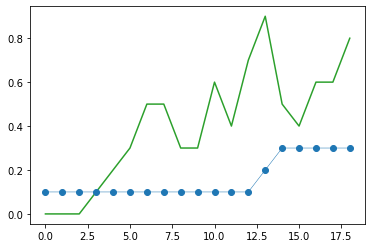

Changing minimax depth to 4
Training


Loss=0.315501, SSLoss=0.000000
Loss=0.314165, SSLoss=0.000000
Loss=0.307966, SSLoss=0.000000

Selfplay



number of new states: 2912
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
2 2
3 3
3 4
4 5
4 6
4 7
4 8
4 9
4 10
0.4


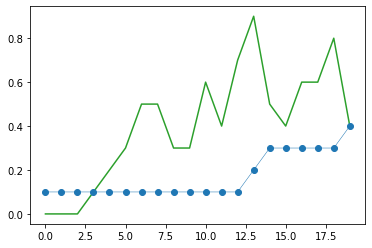

Training


Loss=0.350380, SSLoss=0.000000
Loss=0.338966, SSLoss=0.000000
Loss=0.317485, SSLoss=0.000000

Selfplay



number of new states: 2781
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
1 2
2 3
2 4
3 5
3 6
3 7
4 8
5 9
5 10
0.5


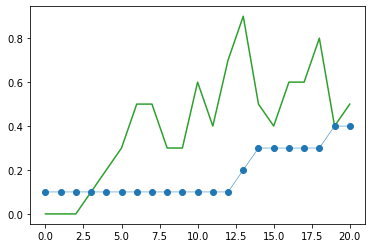

Training


Loss=0.359320, SSLoss=0.000000
Loss=0.355221, SSLoss=0.000000
Loss=0.334201, SSLoss=0.000000

Selfplay



number of new states: 2962
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
1 2
1 3
2 4
3 5
4 6
5 7
6 8
7 9
8 10
0.8


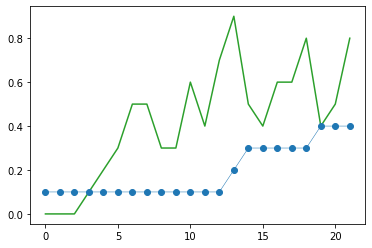

Training


Loss=0.366672, SSLoss=0.000000
Loss=0.360507, SSLoss=0.000000
Loss=0.365879, SSLoss=0.000000

Selfplay



number of new states: 2844
size of game rec / game rec legacy): 30000 33295
Pitting
0 1
1 2
1 3
1 4
2 5
2 6
2 7
2 8
3 9
4 10
0.4


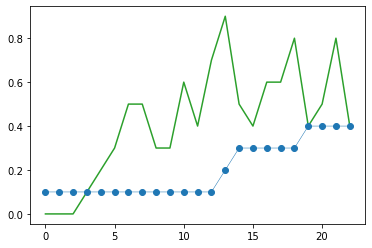

Training


Loss=0.356479, SSLoss=0.000000
Loss=0.366799, SSLoss=0.000000
Loss=0.368222, SSLoss=0.000000

Selfplay



number of new states: 2805
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
1 2
1 3
1 4
2 5
3 6
4 7
5 8
6 9
7 10
0.7


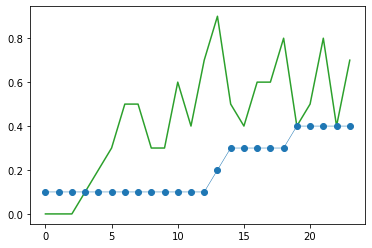

Training


Loss=0.378199, SSLoss=0.000000
Loss=0.378481, SSLoss=0.000000
Loss=0.365646, SSLoss=0.000000

Selfplay



number of new states: 3095
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
2 2
3 3
4 4
5 5
5 6
6 7
7 8
8 9
9 10
0.9


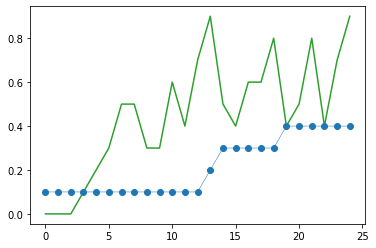

Training


Loss=0.419025, SSLoss=0.000000
Loss=0.401498, SSLoss=0.000000
Loss=0.405119, SSLoss=0.000000

Selfplay



number of new states: 3001
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
1 2
2 3
2 4
2 5
2 6
3 7
4 8
5 9
6 10
0.6


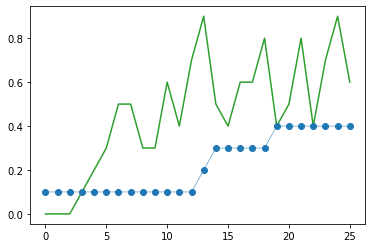

Training


Loss=0.404863, SSLoss=0.000000
Loss=0.439593, SSLoss=0.000000
Loss=0.408397, SSLoss=0.000000

Selfplay



number of new states: 2991
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
2 2
3 3
4 4
5 5
6 6
6 7
6 8
6 9
6 10
0.6


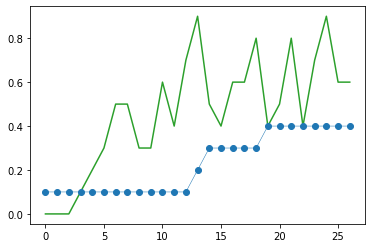

Training


Loss=0.416411, SSLoss=0.000000
Loss=0.441465, SSLoss=0.000000
Loss=0.448967, SSLoss=0.000000

Selfplay



number of new states: 2955
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
2 2
3 3
3 4
3 5
3 6
4 7
5 8
6 9
7 10
0.7


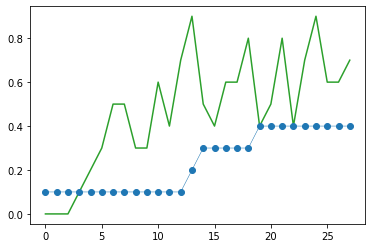

Training


Loss=0.466024, SSLoss=0.000000
Loss=0.466684, SSLoss=0.000000
Loss=0.449372, SSLoss=0.000000

Selfplay



number of new states: 3017
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
1 2
2 3
3 4
4 5
4 6
5 7
5 8
6 9
7 10
0.7


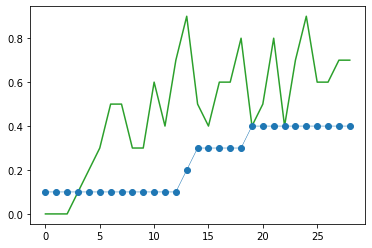

Training


Loss=0.472645, SSLoss=0.000000
Loss=0.461329, SSLoss=0.000000
Loss=0.445775, SSLoss=0.000000

Selfplay



number of new states: 3006
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
2 2
3 3
4 4
5 5
6 6
7 7
7 8
8 9
9 10
0.9


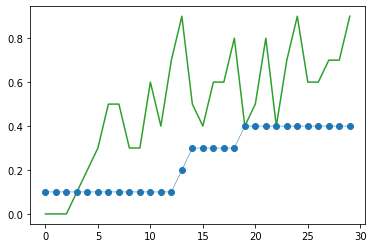

Training


Loss=0.463744, SSLoss=0.000000
Loss=0.475925, SSLoss=0.000000
Loss=0.444710, SSLoss=0.000000

Selfplay



number of new states: 2972
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
2 2
3 3
3 4
4 5
4 6
5 7
5 8
6 9
7 10
0.7


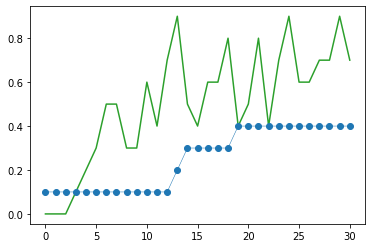

Training


Loss=0.456523, SSLoss=0.000000
Loss=0.454425, SSLoss=0.000000
Loss=0.446253, SSLoss=0.000000

Selfplay



number of new states: 3084
size of game rec / game rec legacy): 30000 33295
Pitting
0 1
0 2
1 3
1 4
2 5
3 6
4 7
4 8
4 9
4 10
0.4


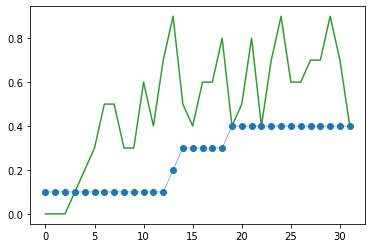

Training


Loss=0.430668, SSLoss=0.000000
Loss=0.420948, SSLoss=0.000000
Loss=0.431936, SSLoss=0.000000

Selfplay



number of new states: 2926
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
2 2
3 3
3 4
4 5
5 6
6 7
7 8
7 9
8 10
0.8


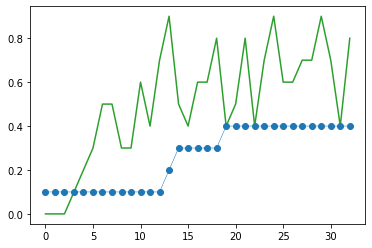

Training


Loss=0.430079, SSLoss=0.000000
Loss=0.414351, SSLoss=0.000000
Loss=0.430823, SSLoss=0.000000

Selfplay



number of new states: 3030
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
1 2
2 3
2 4
3 5
3 6
4 7
4 8
5 9
5 10
0.5


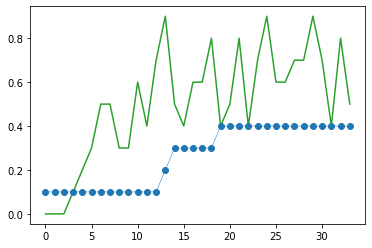

Training


Loss=0.418387, SSLoss=0.000000
Loss=0.401676, SSLoss=0.000000
Loss=0.431015, SSLoss=0.000000

Selfplay



number of new states: 2904
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
2 2
3 3
3 4
4 5
5 6
6 7
6 8
7 9
8 10
0.8


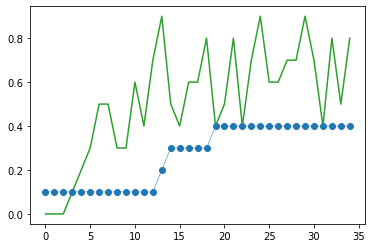

Training


Loss=0.398827, SSLoss=0.000000
Loss=0.399713, SSLoss=0.000000
Loss=0.384190, SSLoss=0.000000

Selfplay



number of new states: 2997
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
1.0


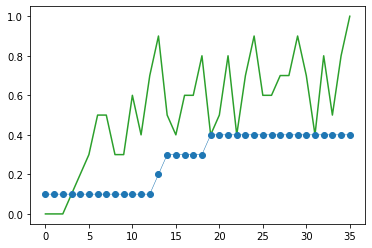

Training


Loss=0.386863, SSLoss=0.000000
Loss=0.390755, SSLoss=0.000000
Loss=0.391597, SSLoss=0.000000

Selfplay



number of new states: 2988
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
2 2
3 3
3 4
4 5
4 6
5 7
6 8
7 9
7 10
0.7


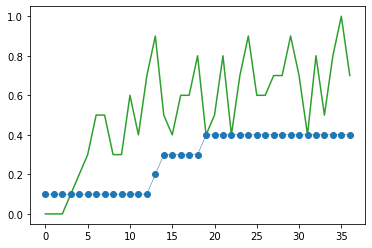

Training


Loss=0.378284, SSLoss=0.000000
Loss=0.380729, SSLoss=0.000000
Loss=0.388042, SSLoss=0.000000

Selfplay



number of new states: 3064
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
1.0


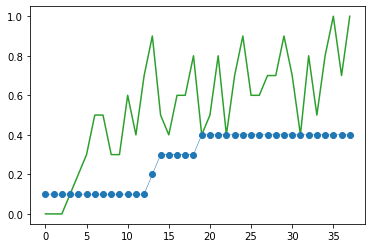

Training


Loss=0.397947, SSLoss=0.000000
Loss=0.386132, SSLoss=0.000000
Loss=0.354941, SSLoss=0.000000

Selfplay



number of new states: 3043
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
2 2
3 3
3 4
4 5
4 6
5 7
6 8
7 9
8 10
0.8


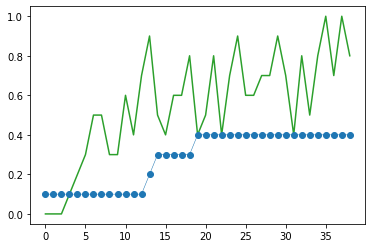

Training


Loss=0.384729, SSLoss=0.000000
Loss=0.358900, SSLoss=0.000000
Loss=0.378154, SSLoss=0.000000

Selfplay



number of new states: 2975
size of game rec / game rec legacy): 30000 33295
Pitting
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
0.9


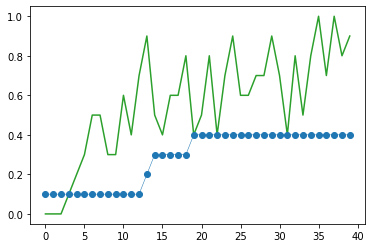

Training


Loss=0.367820, SSLoss=0.000000
Loss=0.373628, SSLoss=0.000000
Loss=0.355244, SSLoss=0.000000

Selfplay



number of new states: 3037
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
2 2
3 3
3 4
4 5
4 6
5 7
5 8
6 9
7 10
0.7


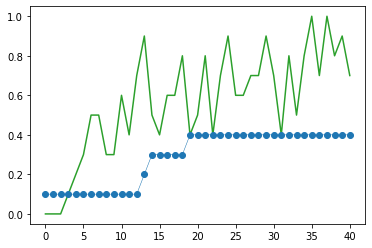

Training


Loss=0.347446, SSLoss=0.000000
Loss=0.351873, SSLoss=0.000000
Loss=0.340078, SSLoss=0.000000

Selfplay



number of new states: 3065
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
2 2
3 3
4 4
5 5
6 6
7 7
7 8
8 9
8 10
0.8


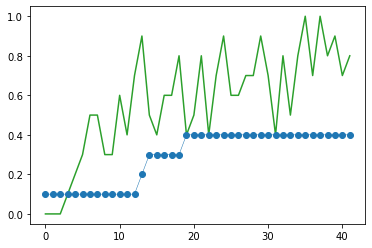

Training


Loss=0.333286, SSLoss=0.000000
Loss=0.341226, SSLoss=0.000000
Loss=0.337255, SSLoss=0.000000

Selfplay



number of new states: 2961
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
2 2
3 3
3 4
4 5
5 6
6 7
7 8
8 9
8 10
0.8


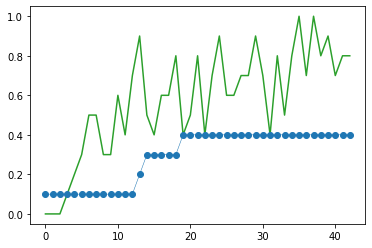

Training


Loss=0.325789, SSLoss=0.000000
Loss=0.307005, SSLoss=0.000000
Loss=0.315069, SSLoss=0.000000

Selfplay



number of new states: 2961
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
2 2
3 3
3 4
4 5
4 6
5 7
5 8
6 9
7 10
0.7


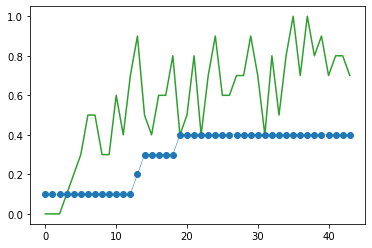

Training


Loss=0.326832, SSLoss=0.000000
Loss=0.314851, SSLoss=0.000000
Loss=0.326278, SSLoss=0.000000

Selfplay



number of new states: 2995
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
1 2
2 3
3 4
4 5
4 6
5 7
6 8
7 9
8 10
0.8


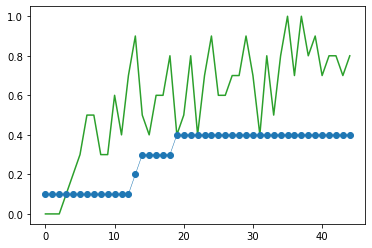

Training


Loss=0.312279, SSLoss=0.000000
Loss=0.327648, SSLoss=0.000000
Loss=0.295696, SSLoss=0.000000

Selfplay



number of new states: 3157
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
2 2
3 3
4 4
5 5
6 6
7 7
7 8
8 9
9 10
0.9


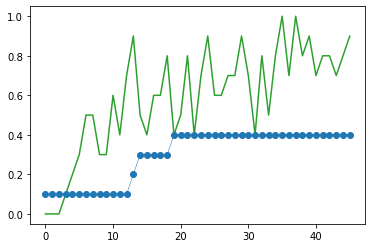

Training


Loss=0.309577, SSLoss=0.000000
Loss=0.300195, SSLoss=0.000000
Loss=0.313211, SSLoss=0.000000

Selfplay



number of new states: 2934
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
2 2
3 3
4 4
5 5
5 6
6 7
7 8
8 9
9 10
0.9


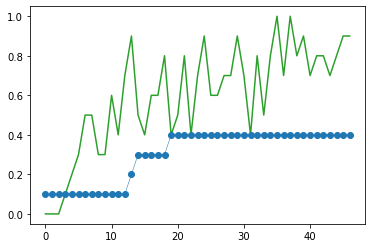

Training


Loss=0.301227, SSLoss=0.000000
Loss=0.296626, SSLoss=0.000000
Loss=0.294494, SSLoss=0.000000

Selfplay



number of new states: 2976
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
2 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
0.9


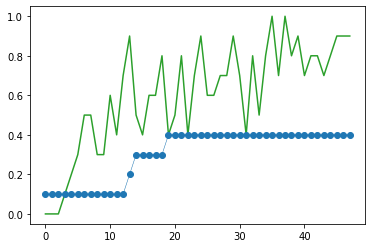

Training


Loss=0.309822, SSLoss=0.000000
Loss=0.311077, SSLoss=0.000000
Loss=0.307597, SSLoss=0.000000

Selfplay



number of new states: 2910
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
2 2
3 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
0.9


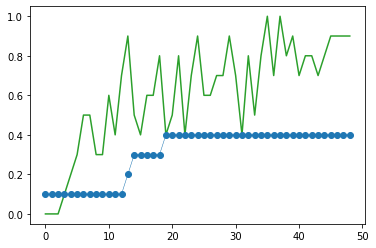

Training


Loss=0.298051, SSLoss=0.000000
Loss=0.303372, SSLoss=0.000000
Loss=0.280721, SSLoss=0.000000

Selfplay



number of new states: 2954
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
9 10
0.9


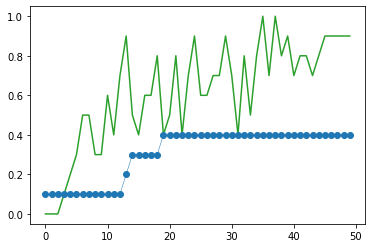

Training


Loss=0.298254, SSLoss=0.000000
Loss=0.304337, SSLoss=0.000000
Loss=0.279953, SSLoss=0.000000

Selfplay



number of new states: 2979
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
1 2
2 3
3 4
4 5
4 6
5 7
6 8
7 9
8 10
0.8


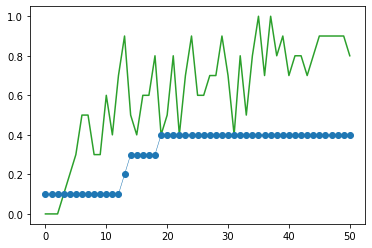

Training


Loss=0.304828, SSLoss=0.000000
Loss=0.297896, SSLoss=0.000000
Loss=0.287623, SSLoss=0.000000

Selfplay



number of new states: 2932
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
2 2
3 3
4 4
5 5
5 6
6 7
7 8
8 9
9 10
0.9


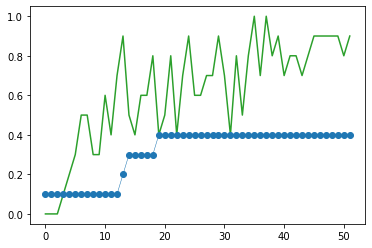

Training


Loss=0.308429, SSLoss=0.000000
Loss=0.283849, SSLoss=0.000000
Loss=0.310196, SSLoss=0.000000

Selfplay



number of new states: 3082
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
2 2
3 3
4 4
5 5
5 6
6 7
7 8
8 9
8 10
0.8


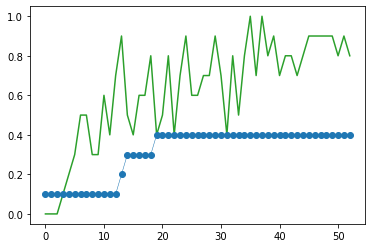

Training


Loss=0.307533, SSLoss=0.000000
Loss=0.316758, SSLoss=0.000000
Loss=0.296046, SSLoss=0.000000

Selfplay



number of new states: 2997
size of game rec / game rec legacy): 30000 33295
Pitting
1 1
2 2
3 3
4 4
5 5
6 6
7 7
7 8
8 9
9 10
0.9


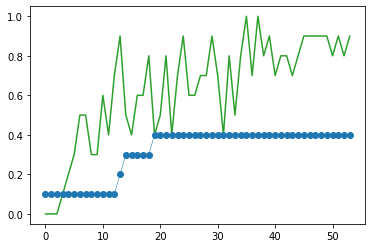

Training


Loss=0.296363, SSLoss=0.000000
Loss=0.302106, SSLoss=0.000000
Loss=0.305093, SSLoss=0.000000

Selfplay


KeyboardInterrupt: 

In [14]:
## game_rec = []

#net = Net()
##net.load_state_dict(torch.load('net_train_selfplay.dat'))


#stage = 2

while True:

    
    # Evaluate/Pit
    if stage==0:
        print('Pitting')
        winrate = pit(MultiMCTS(nparallel=5, nsearches=150, net=net), MiniMax(maxdepth=depthminimax), n=10, nrnd=1, verbose=1)
        print(winrate)
        winrates.append(winrate)
        mmdepths.append(depthminimax)
        plt.plot(winrates, 'C2')
        plt.plot(np.array(mmdepths)/10, 'C0o-', lw=0.5)
        plt.show()
        if winrate>=0.7 and depthminimax<4:
            depthminimax += 1
            print(f'Changing minimax depth to {depthminimax}')
        stage = 1
    
    
    # Train
    if stage==1:
        print('Training')
        net = train(net, game_rec, game_rec_leg, iterations=300, verbose=1)
        torch.save(net.state_dict(), 'net_temp.dat')
        stage = 2
    
    
    # Selfplay
    if stage==2:
        print('Selfplay')
        #newgames = selfplay(MultiMCTS(nparallel=5, nsearches=50, net=net), ngames=200, verbose=1)
        newgames = selfplay_batched(BatchMCTS(nparallel=20, nsearches=50, net=net), ngames=200, verbose=1)
        game_rec = newgames + game_rec
        ##game_rec_leg = game_rec[30000:] + game_rec_leg
        ##game_rec_leg = game_rec_leg[:150000]
        game_rec = game_rec[:30000]
        print('number of new states:', len(newgames))
        print('size of game rec / game rec legacy):', len(game_rec), len(game_rec_leg))
        stage=0
    

In [17]:
import pickle as pkl
pkl.dump(game_rec, open('selfplay50.dat', 'wb'))

In [49]:
from hex_mcts import *

In [163]:

#ai1 = MultiMCTS(net='net_selfplay50.dat', nparallel=25, nsearches=1000)
#ai2 = MultiMCTS(net='net_selfplay50.dat', nparallel=25, nsearches=500)


ai1 = MultiMCTS(net='net_selfplay50.dat', nparallel=20, nsearches=1000)
ai2 = MultiMCTS(net='net_selfplay50.dat', nparallel=20, nsearches=1000)
ai2.cuncert = 4

In [164]:
pit(ai1, ai2, n=100, nrnd=1, verbose=1)

# 4:   .55
# 4.5: .55
# 5:   .65

1 1
1 2
1 3
2 4
3 5
3 6
4 7
4 8
5 9
6 10
7 11
8 12
9 13
9 14
10 15
10 16


KeyboardInterrupt: 

In [20]:
show_board(game[12][0])

IndexError: list index out of range

In [9]:
ai1 = MiniMax(maxdepth=3)
ai2 = MiniMax(maxdepth=3)

ai1.bridges=True

pit(ai1, ai2, nrnd=2, verbose=1)

0 1
1 2


KeyboardInterrupt: 